In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input

from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
data_path = 'C:/Users/maria/OneDrive/Documentos/Github/ECG-anomaly-detection/data/processed/'
df_normal = pd.read_parquet(data_path + 'ptdb_normal.parquet')
df_anomaly = pd.read_parquet(data_path + 'ptdb_abnormal.parquet')

In [3]:
df_normal = df_normal.replace(0, np.nan)
df_anomaly = df_anomaly.replace(0, np.nan)

In [4]:
df_normal.drop(columns=['Mean','Skewness','Kurtosis','Std'],inplace=True)
df_anomaly.drop(columns=['Mean','Skewness','Kurtosis','Std'], inplace=True)

In [5]:
df_normal = df_normal.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
df_anomaly = df_anomaly.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

In [6]:
# Drop columns with all NaN values
df_normal = df_normal.dropna(axis=1, how='all')
df_anomaly = df_anomaly.dropna(axis=1, how='all')

In [7]:
df_normal['label'] = 0
df_anomaly['label'] = 1

In [8]:
def prepare_autoencoder_data(normal_df, anomaly_df):
       
    X_train = normal_df.iloc[:-809,:-1]
    y_train = normal_df.iloc[:-809]['label']
    
    # Separating the features and labels of normal data for validation
    
    X_val = normal_df.iloc[-809:, :-1]
    y_val = normal_df.iloc[-809:]['label']
    
    # Separating the features and labels of anomaly data
    X_test = anomaly_df.iloc[:, :-1]
    y_test = anomaly_df['label']   
        
    # Resetting the indices of the DataFrames
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = prepare_autoencoder_data(df_normal, df_anomaly)

print(f'Training set size: {X_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Test set size: {X_test.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(X_train)
val_data = scaler.transform(X_val)
test_data = scaler.transform(X_test)

Training set size: (3237, 187)
Validation set size: (809, 187)
Test set size: (10506, 187)


### LSTM input 

Here we transform the input data into the format expected by LSTM models, which work with sequences of timesteps.

In [9]:
df_normal

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.136143,0.136143,0.136143,0.136143,0.136143,0.136143,0.136143,0.136143,0.136143,0
1,1.000000,0.794681,0.375387,0.116883,0.116883,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.416821,0.416821,0.416821,0.416821,0.416821,0.416821,0.416821,0.416821,0.416821,0
2,0.909029,0.791482,0.423169,0.186712,0.186712,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.270187,0.270187,0.270187,0.270187,0.270187,0.270187,0.270187,0.270187,0.270187,0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.086994,0.086994,0.086994,0.086994,0.086994,0.086994,0.086994,0.086994,0.086994,0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.083383,0.083383,0.083383,0.083383,0.083383,0.083383,0.083383,0.083383,0.083383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.140237,0.140237,0.140237,0.140237,0.140237,0.140237,0.140237,0.140237,0.140237,0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.114973,0.114973,0.114973,0.114973,0.114973,0.114973,0.114973,0.114973,0.114973,0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.265847,0.265847,0.265847,0.265847,0.265847,0.265847,0.265847,0.265847,0.265847,0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.217912,0.217912,0.217912,0.217912,0.217912,0.217912,0.217912,0.217912,0.217912,0


In [10]:
timesteps = 10  # Adjust this value to see its effect
n_features = X_train.shape[1] // timesteps

X_train = X_train.iloc[:, :n_features * timesteps]
X_train = X_train.values.reshape((X_train.shape[0], timesteps, n_features))

X_val = X_val.iloc[:, :n_features * timesteps]
X_val = X_val.values.reshape((X_val.shape[0], timesteps, n_features))

X_test = X_test.iloc[:, :n_features * timesteps]
X_test = X_test.values.reshape((X_test.shape[0], timesteps, n_features))

In [11]:
train_data = tf.cast(X_train, tf.float32)
val_data = tf.cast(X_val, tf.float32)
test_data = tf.cast(X_test, tf.float32)

In [12]:
# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    Input(shape=(timesteps, n_features)),
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 18)         │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train the model
history = lstm_autoencoder.fit(
    train_data, train_data, 
    epochs=60, 
    batch_size=32, 
    validation_data=(val_data,val_data),
    shuffle=True
)

Epoch 1/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 2/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 10/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 

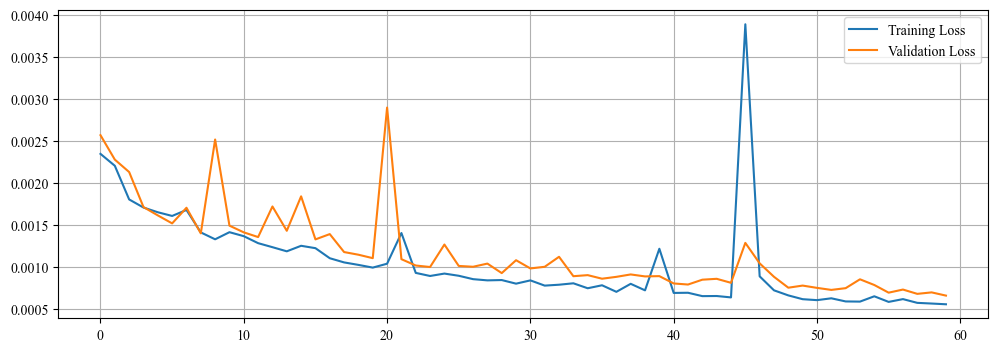

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid(True)
plt.legend()

## Reconstruction of normal data
Let's first examine how well the model reconstructs the normal data before attempting to detect anomalies in the abnormal signals.

In [40]:
def LSTM_reconstruction(autoencoder, test_data,N, M, sample_index):
    # Reconstruct the data   
    decoded_data = autoencoder.predict(test_data)
    decoded_data = decoded_data.reshape(N, M)
    t = np.arange(0,M,1)
    test_data = test_data.reshape(N,M)

    
    # Plot the original and reconstructed data
    plt.figure(figsize=(12, 4))
    plt.plot(t, test_data[sample_index], 'b', label="Input")
    plt.plot(t, decoded_data[sample_index], 'r', label="Reconstruction")
    plt.fill_between(np.arange(len(test_data[sample_index])), decoded_data[sample_index], test_data[sample_index], color='lightcoral', label="Error")
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('LSTM AE', size =14)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


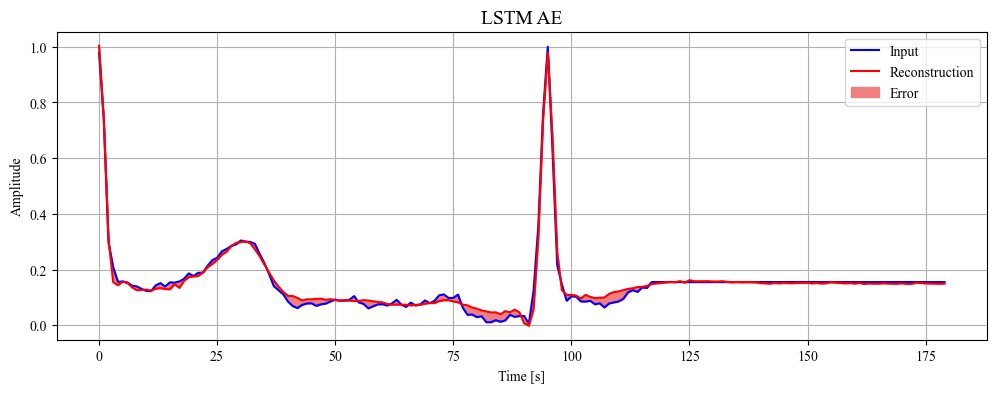

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


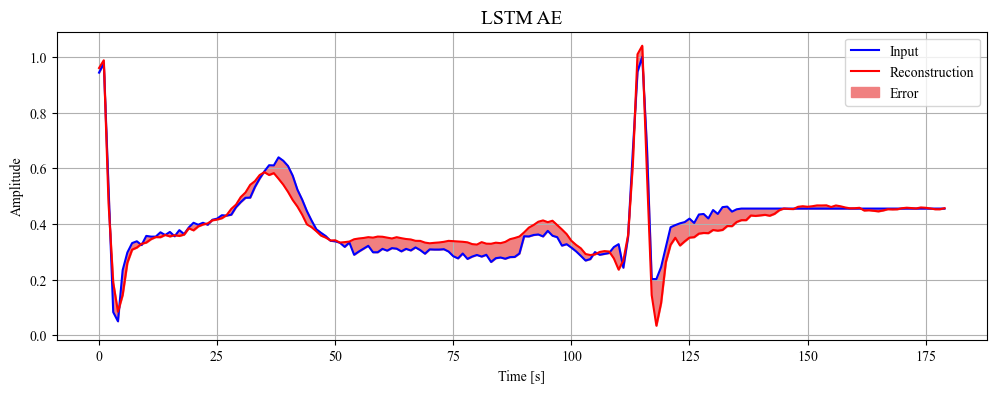

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


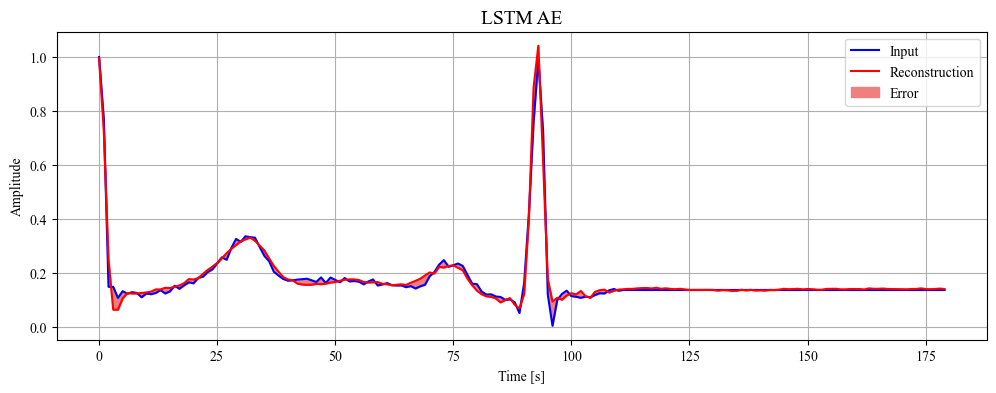

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


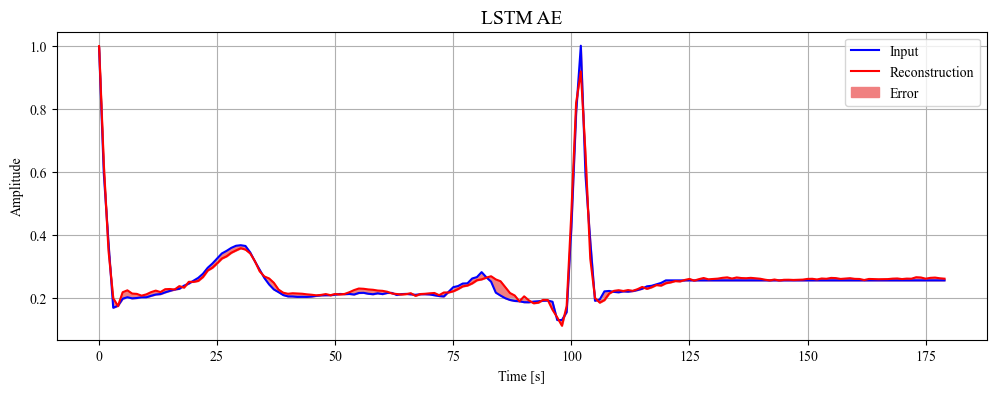

In [41]:
for i in range(1,5):
    LSTM_reconstruction(lstm_autoencoder, X_val, N=809, M=180, sample_index=i)

By using an LSTM architecture, the model successfully identified rare peaks that can appear in normal data, which is crucial for this problem. Next, let’s see if we can detect anomalies in abnormal data.

## Detecting abnormal data

Let's evaluate how our model reconstructs the abnormal data. The expectation is that the model will not reconstruct abnormal data well. By examining the reconstruction error, we can establish a threshold. If the error exceeds this threshold, the data point is classified as an anomaly

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


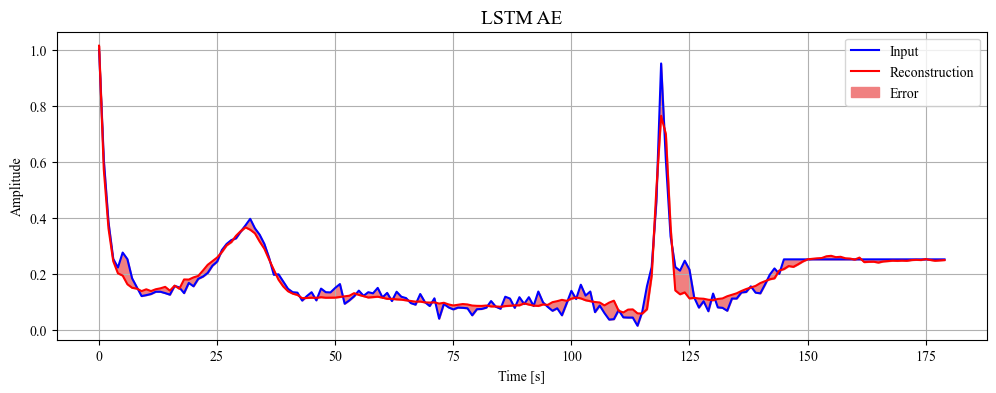

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


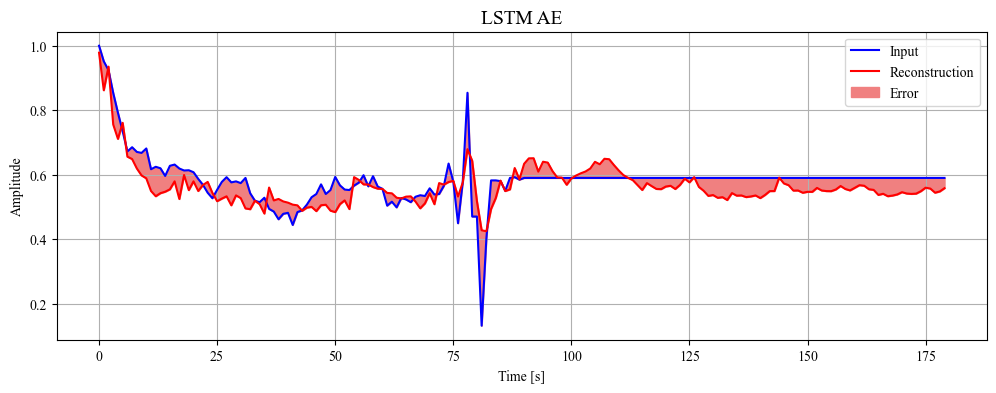

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


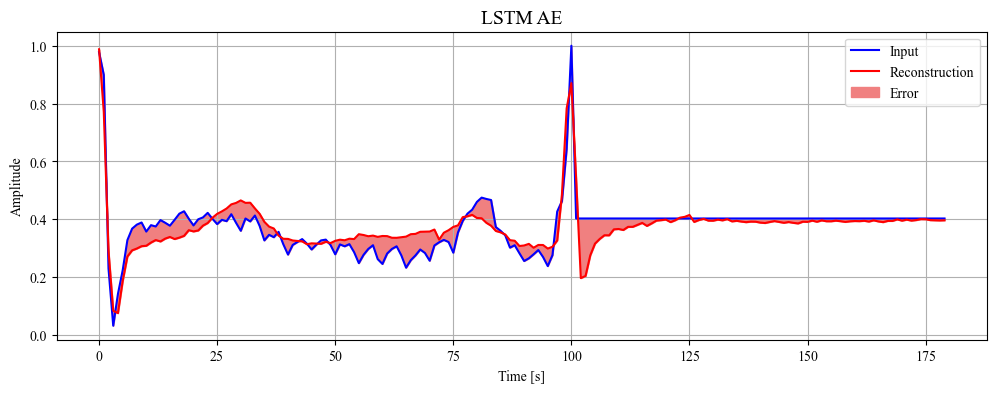

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


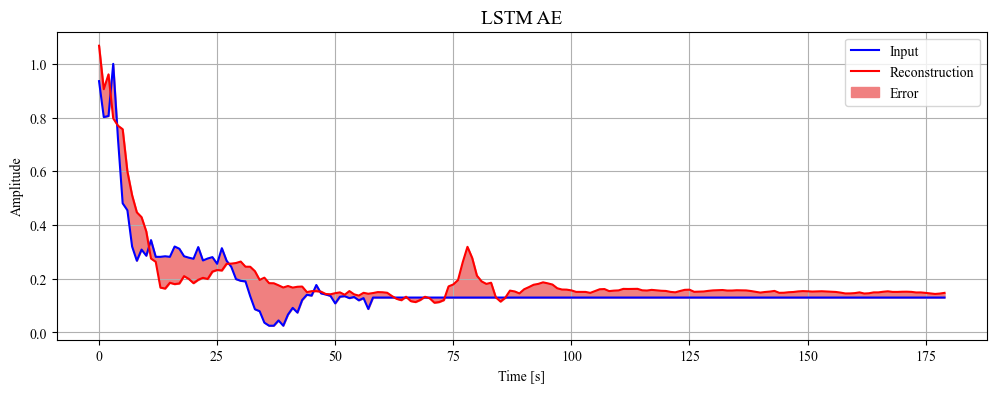

In [42]:
for i in range(1,5):
    LSTM_reconstruction(lstm_autoencoder, X_test, N=X_test.shape[0], M=180, sample_index=i)

## Threshold definition

In [43]:
def error_threshold(autoencoder, train_data, N, M):
    # Reconstruct the training data
    train_predictions = autoencoder.predict(train_data)
    train_predictions = train_predictions.reshape(N, M)
    train_data = train_data.reshape(N, M)
    
    # Calculate the train MSE
    train_errors = np.square(train_data - train_predictions).mean(axis=1)
    error= np.square(train_data - train_predictions).flatten()
    # Define the threshold for anomaly detection
    threshold = train_errors.mean() + 8*train_errors.std()
    
    # Plot the error distribution for the train data
    plt.figure(figsize=(8, 4))
    plt.hist(error, bins=200, alpha=0.75, color='blue', edgecolor='black',density=True)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Validation Error Distribution')
    plt.xlim([None,0.10])
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return threshold

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


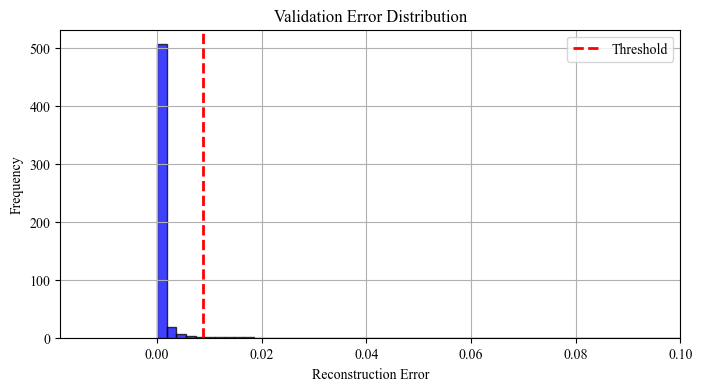

In [44]:
threshold = error_threshold(lstm_autoencoder, X_val, N=809, M=180)

In [49]:
def LSTM_anomaly_detection(autoencoder, test_data, threshold, N, M, sample_index):
    # Reconstruct the data   
    decoded_data = autoencoder.predict(test_data)
    decoded_data = decoded_data.reshape(N, M)
    t = np.arange(0,M,1)
    test_data = test_data.reshape(N,M)
    
    # Calculate mean squared error between the test data and reconstructed data
    val_mse = np.square(test_data - decoded_data)
    
    # Identify anomalies (boolean matrix)
    anomalies = val_mse > threshold
    
    # Check if there are any anomalies in the series
    if np.any(anomalies[sample_index]):
        print("Anomalies detected in the series.")
    else:
        print("No anomalies detected in the series.")
    
    # Plot the original and reconstructed data for a sample
    plt.figure(figsize=(12, 4))
    plt.plot(t, test_data[sample_index], 'b', label="Input")
    plt.plot(t, decoded_data[sample_index], 'r', label="Reconstruction")
    
    # Highlight anomalies
    anomaly_indices = np.where(anomalies[sample_index])[0]
    if anomaly_indices.size > 0:
        plt.scatter(anomaly_indices, test_data[sample_index][anomaly_indices], color='orange', s=40, label='Anomaly')
    
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('LSTM AE with Anomalies', size=14)
    plt.legend()
    plt.grid(True)
    plt.show()

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Anomalies detected in the series.


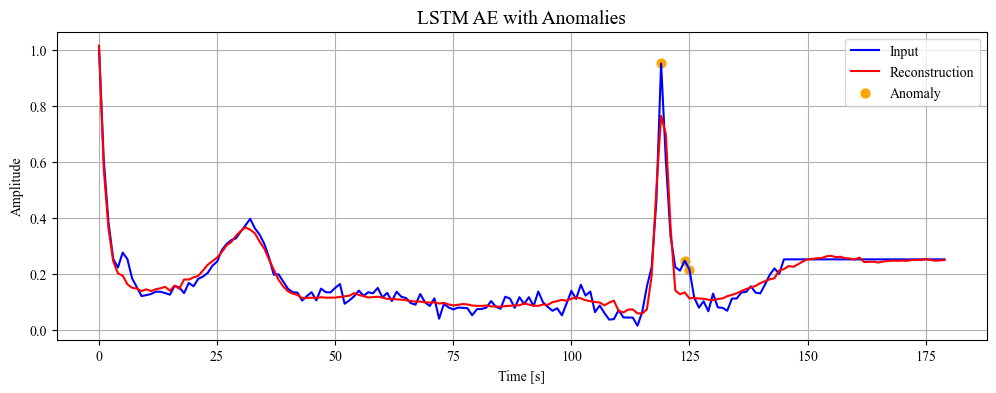

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Anomalies detected in the series.


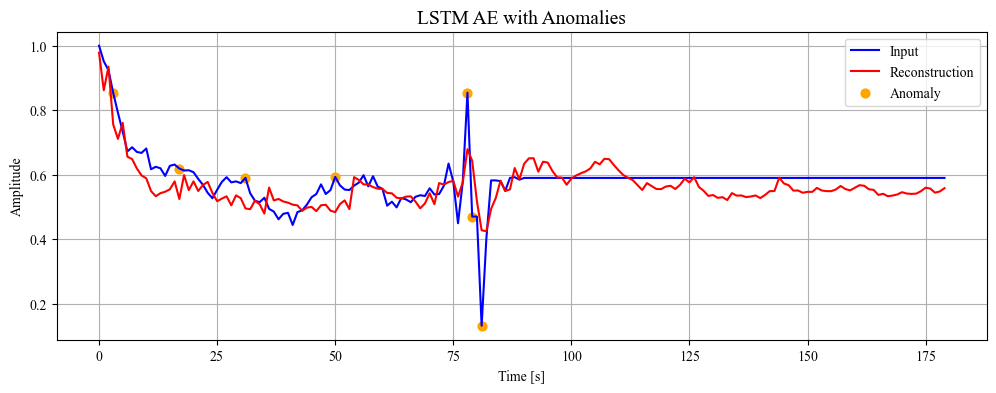

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Anomalies detected in the series.


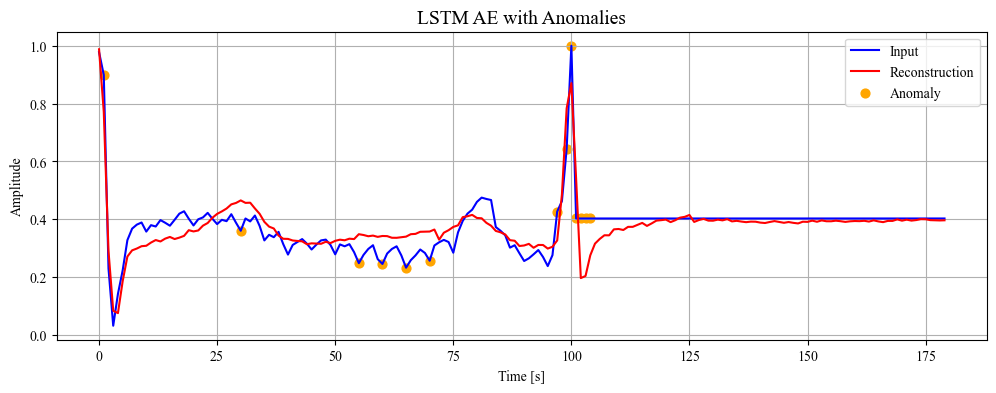

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Anomalies detected in the series.


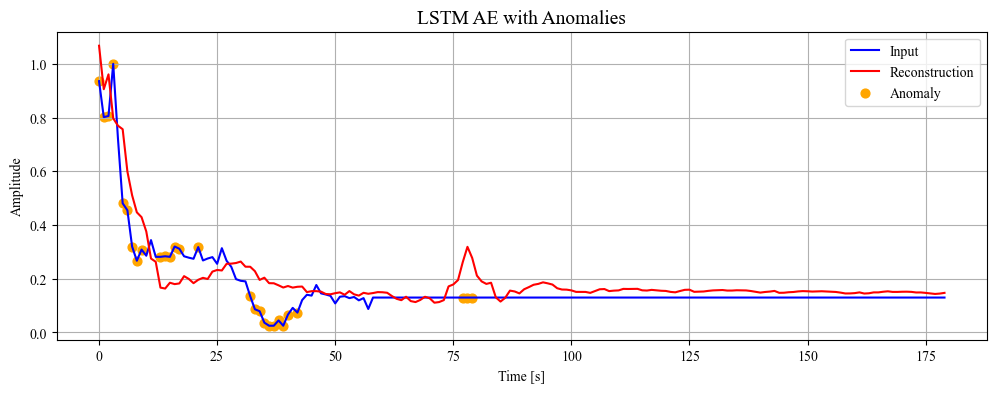

In [50]:
for i in range(1,5):
    LSTM_anomaly_detection(lstm_autoencoder, X_test, threshold = threshold, N=X_test.shape[0], M=180, sample_index=i)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
No anomalies detected in the series.


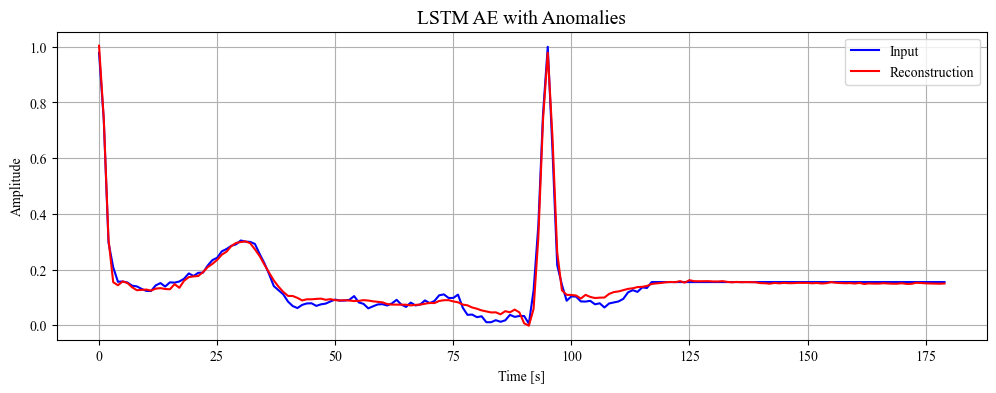

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Anomalies detected in the series.


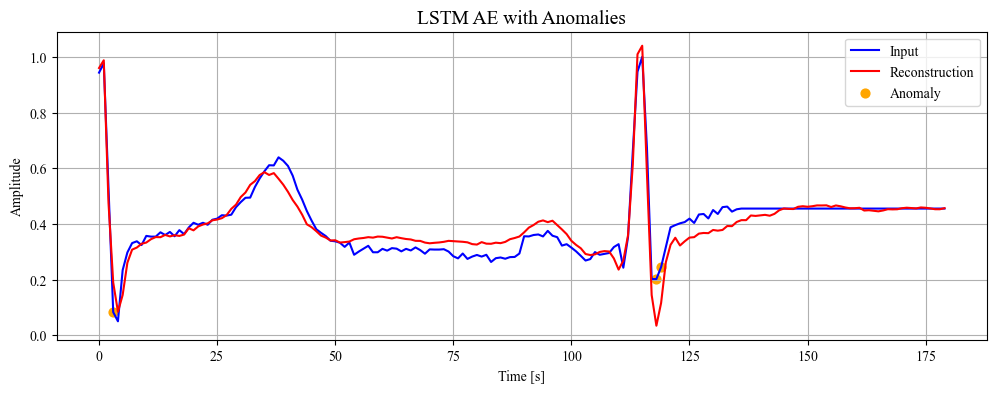

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Anomalies detected in the series.


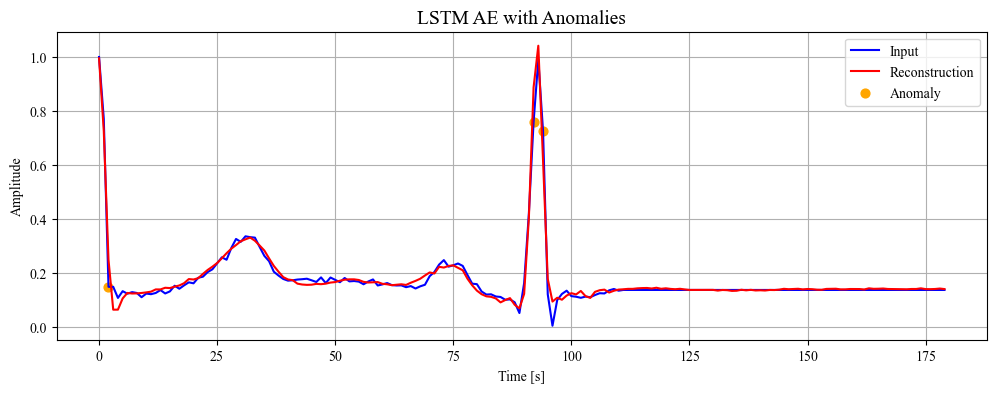

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
No anomalies detected in the series.


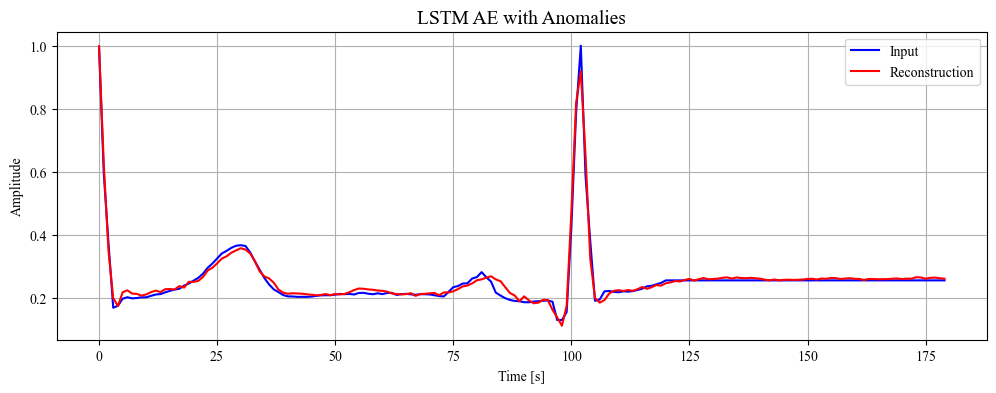

In [51]:
for i in range(1,5):
    LSTM_anomaly_detection(lstm_autoencoder, X_val, threshold = threshold, N=X_val.shape[0], M=180, sample_index=i)

We have successfully defined a threshold that accurately identifies anomalies in the abnormal data, with only a few false positives among the normal data. Additionally, the model can be further calibrated to ensure that isolated points do not erroneously indicate an anomaly. Moreover, it is important to note that the model's hyperparameters have not yet been fine-tuned, leaving room for potential improvements in performance.